# Importing required Libraries

In [1]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=10921c3f18ee510dc4c8e5a9789e391ef155d098c34ed85b3680d71a9a2c14b1
  Stored in directory: /root/.cache/pip/wheels/65/56/4a/4b967e4b9b62bd9d8d7ca789bba648c702d705487f28845bb2
Successfully built ipython-autotime


In [2]:
import os,re
import unicodedata
import gc
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import tensorflow as tf

from tqdm.notebook import tqdm
from numba import jit, cuda 

import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist

time: 2.52 s


# Reading Data

In [3]:
# the data paths
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
translated_data_path = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

# loading all the train datasets

train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
# train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path + 'validation.csv')
# validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')
valid_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_valid_translated.csv')

# test_data1 = pd.read_csv(data_path + 'test.csv')
# test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')
test_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_test_translated.csv')

time: 20 s


# Toxic and Non-Toxic comments in data

Text(0.5, 0.98, 'Number of toxic and non-toxic values in all the data')

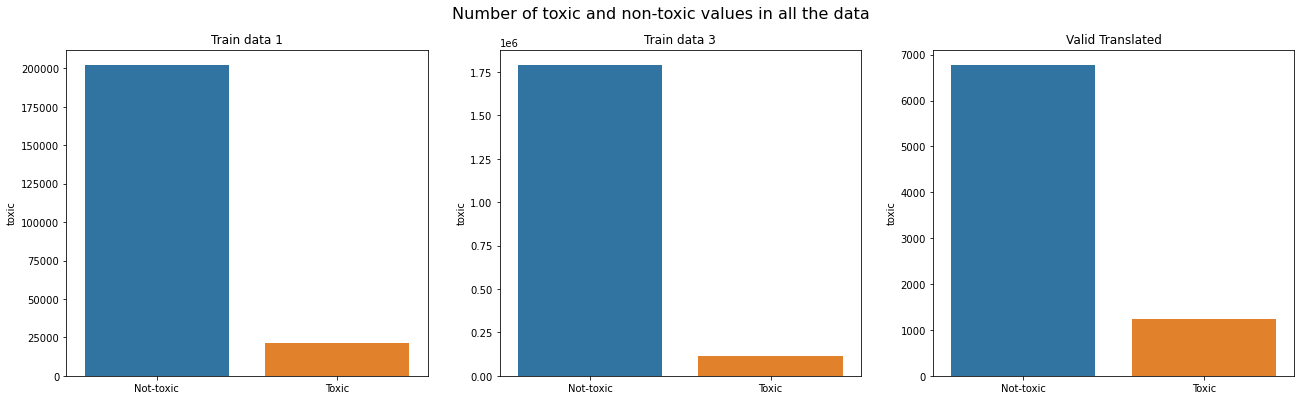

time: 516 ms


In [4]:
fig = plt.figure(figsize=(22,6))
plt.subplot(1,3,1)
sns.barplot(x=['Not-toxic', 'Toxic'], y=train_data1.toxic.value_counts())
plt.title('Train data 1')

plt.subplot(1,3,2)
sns.barplot(x=['Not-toxic', 'Toxic'], y=train_data3.toxic.round().astype(int).value_counts())
plt.title('Train data 3')

plt.subplot(1,3,3)
sns.barplot(x=['Not-toxic', 'Toxic'], y=valid_translated.toxic.value_counts())
plt.title('Valid Translated')

fig.suptitle('Number of toxic and non-toxic values in all the data',fontsize=16)

# Toxic and non toxic comments by language in validation data

In [5]:
valid_lang = valid_translated.groupby(['lang','toxic']).count()[['id']]
valid_lang

id
lang toxic      
es   0      2078
     1       422
it   0      2012
     1       488
tr   0      2680
     1       320

time: 28.8 ms


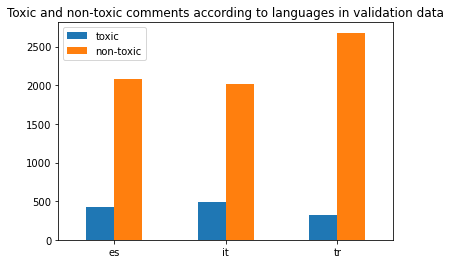

time: 189 ms


In [6]:
pd.DataFrame({'toxic': valid_lang.id[1::2].to_list(),
              'non-toxic': valid_lang.id[0::2].to_list()},
             index=['es','it','tr']).plot.bar(rot=0,title='Toxic and non-toxic comments according to languages in validation data')

# Language percentage distribution in Test data

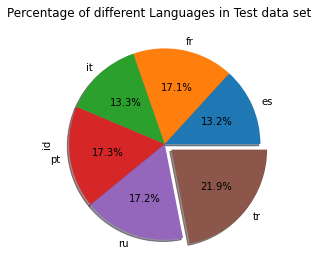

time: 146 ms


In [7]:
q = test_translated.groupby(['lang']).count()[['id']].plot(kind='pie',
                                                       subplots=True,
                                                       autopct='%1.1f%%',
                                                       legend=False,
                                                       explode=(0,0,0,0,0,0.1),
                                                       title='Percentage of different Languages in Test data set',
                                                       shadow=True,
                                                       radius=1.1)

# Word cloud of comments

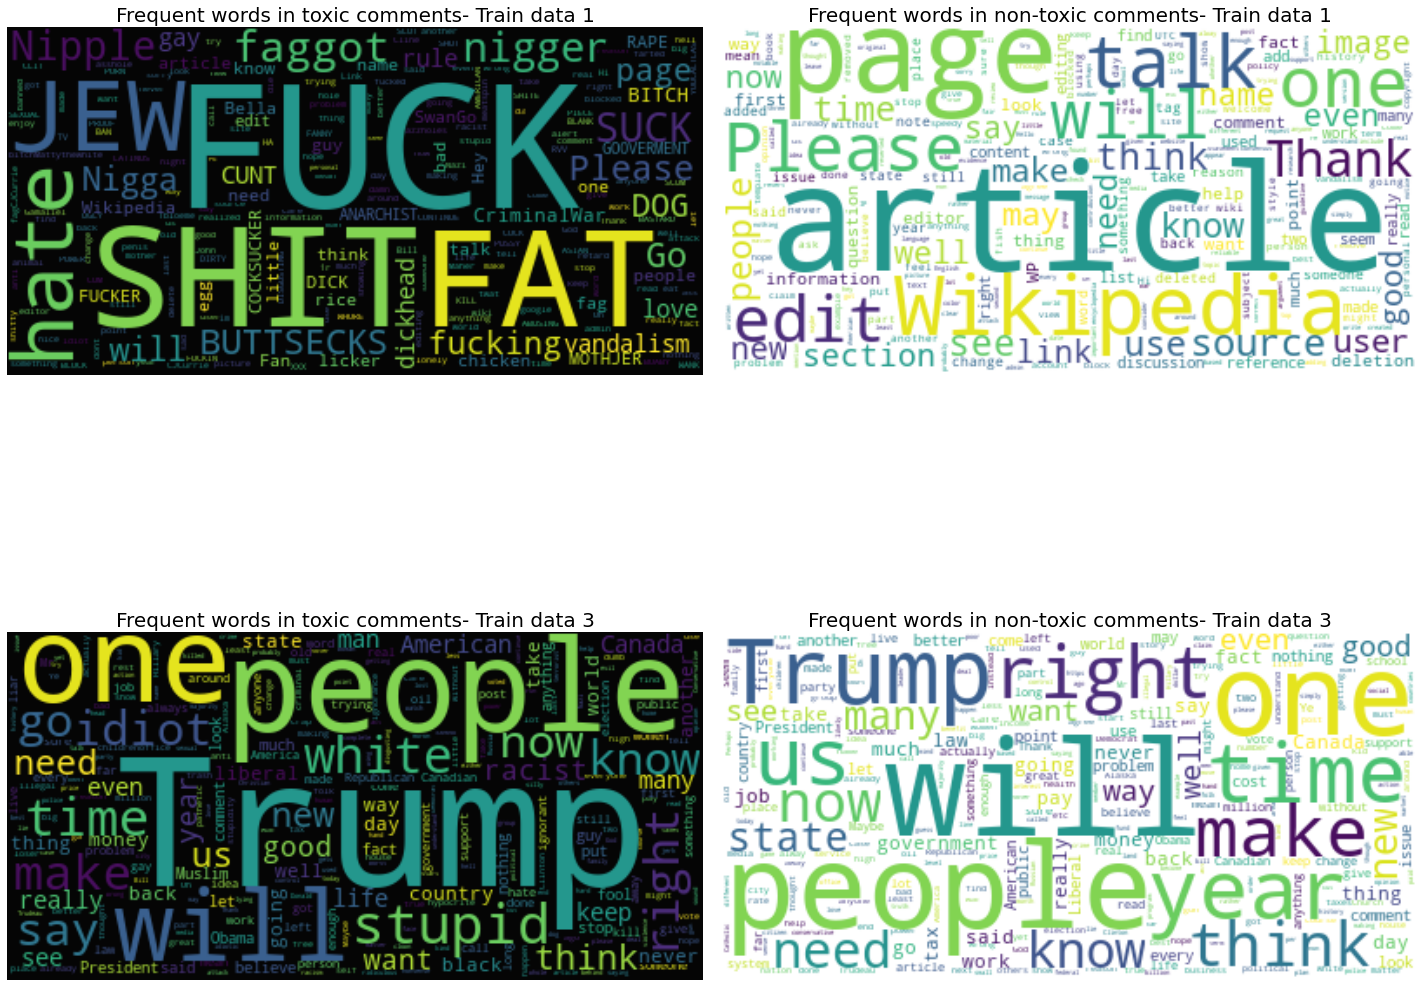

time: 10.7 s


In [8]:
wc = WordCloud(background_color="black", max_words=4000, stopwords=STOPWORDS, collocations=False)
wc.generate(" ".join(train_data1.sample(n=20000).query('toxic==1').comment_text.values))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Frequent words in toxic comments- Train data 1", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation='bilinear')


wc = WordCloud(background_color="white", max_words=4000, stopwords=STOPWORDS, collocations=False)
wc.generate(" ".join(train_data1.sample(n=30000).query('toxic==0').comment_text.values))
plt.subplot(222)
plt.axis("off")
plt.title("Frequent words in non-toxic comments- Train data 1", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation='bilinear')


wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS,collocations=False)
wc.generate(" ".join(train_data3.sample(n=20000).round().query('toxic==1').comment_text.values))
plt.subplot(223)
plt.axis("off")
plt.title("Frequent words in toxic comments- Train data 3", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation='bilinear')


wc = WordCloud(background_color="white", max_words=2000, stopwords=STOPWORDS,collocations=False)
wc.generate(" ".join(train_data3.sample(n=40000).round().query('toxic==0').comment_text.values))
plt.subplot(224)
plt.axis("off")
plt.title("Frequent words in non-toxic comments- Train data 3", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation='bilinear')

plt.tight_layout()
plt.show()

# Frequency of words Used

In [9]:
# # import ast
# mostcommon=FreqDist(" ".join(train_data1.sample(n=20000).query('toxic==1').comment_text.values).split()).most_common(250)
# # l2 = ast.literal_eval(str(mostcommon))
# # print(*l2)
# wc = WordCloud(background_color="black", max_words=4000, stopwords=STOPWORDS).generate(str(mostcommon))
# plt.figure(figsize=(20,20))
# plt.subplot(221)
# plt.axis("off")
# plt.title("Frequent words in toxic comments- Train data 1", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation = 'bilinear')

time: 517 µs


In [10]:
# mostcommon=FreqDist(" ".join(train_data1.sample(n=20000).query('toxic==1').comment_text.values).split()).most_common(25)
# x,y=zip(*mostcommon)
# plt.figure(figsize=(20,20))
# plt.margins(.02)
# plt.bar(x,y)
# plt.xlabel('Words')
# plt.ylabel('Frequency')
# plt.xticks(rotation=60)
# plt.title('Frequency of 25 Most Common Toxic Words in Train Data 1')
# plt.show()

time: 485 µs


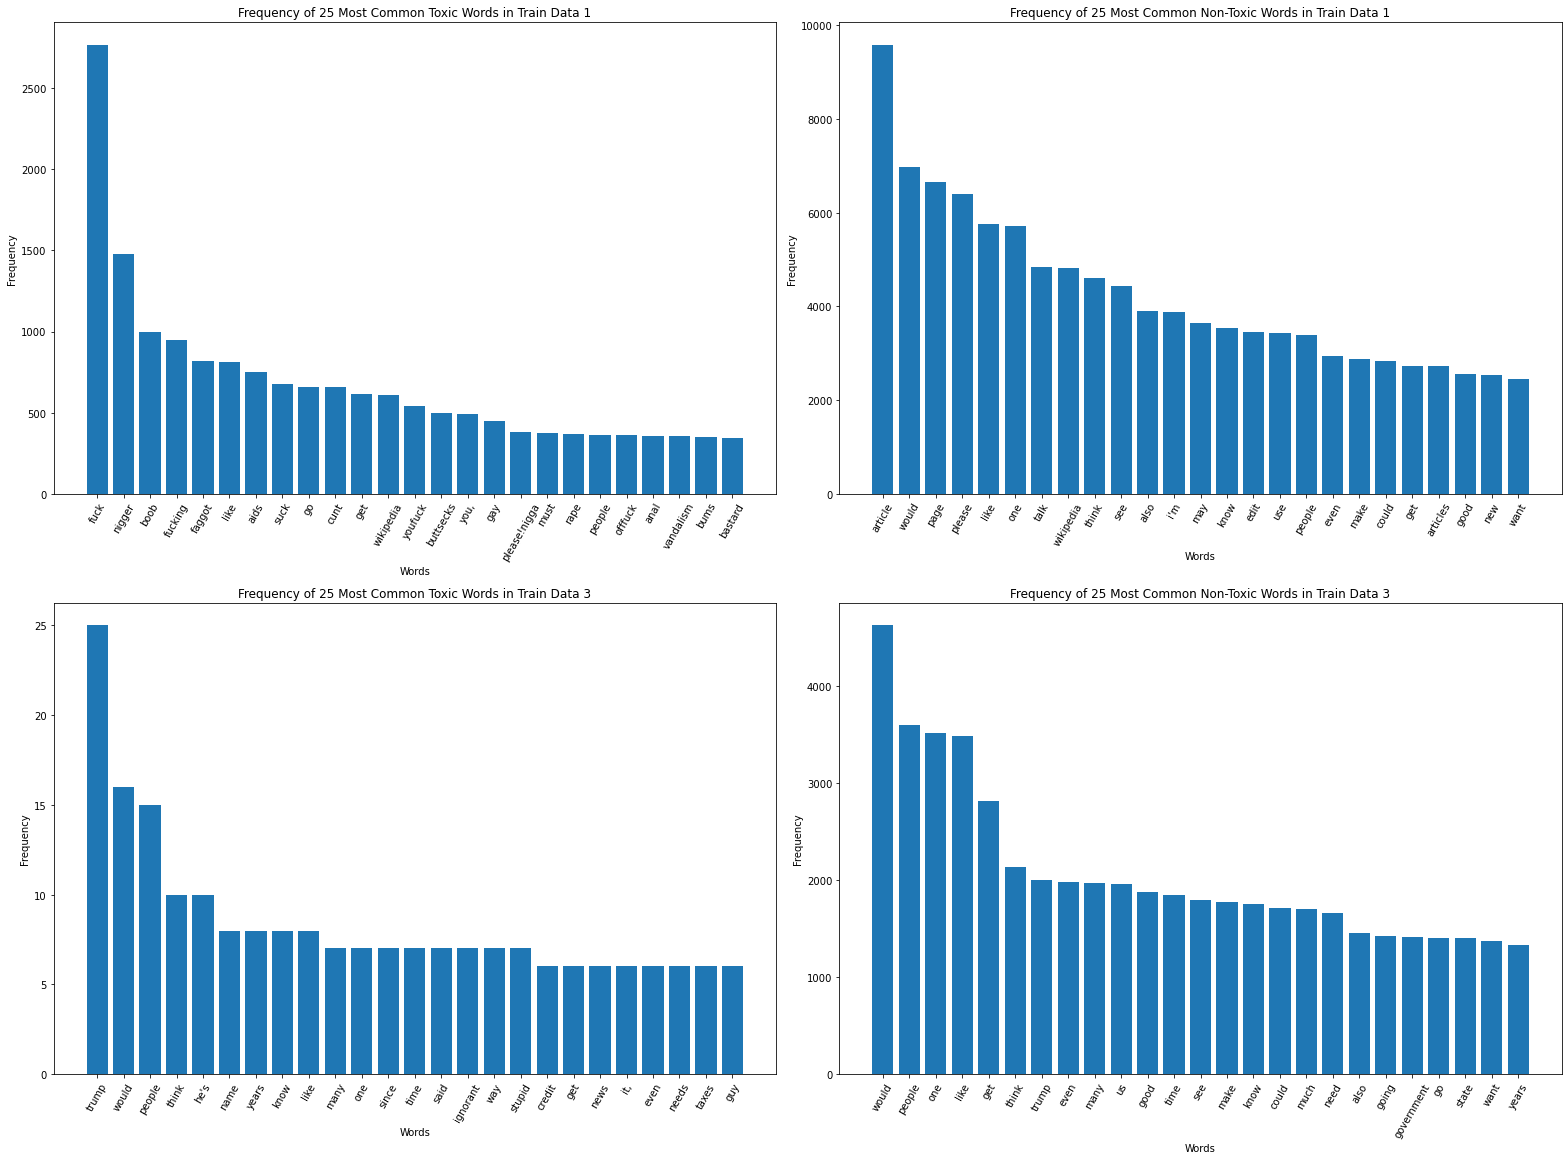

time: 6.76 s


In [11]:
fig=plt.figure(figsize=(22,16))

plt.subplot(221)
stopword_set = set(nltk.corpus.stopwords.words('english'))
stopword_set.update(["==","u",'"','c','-'])
word_list1=" ".join(train_data1.sample(n=40000).query('toxic==1').comment_text.values).split()
most_common1=nltk.FreqDist(w.lower() for w in word_list1 if w.lower() not in stopword_set).most_common(25)
x,y=zip(*most_common1)
plt.tight_layout()
plt.bar(x,y)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Toxic Words in Train Data 1')

plt.subplot(222)
word_list1=" ".join(train_data1.sample(n=40000).query('toxic==0').comment_text.values).split()
most_common1=nltk.FreqDist(w.lower() for w in word_list1 if w.lower() not in stopword_set).most_common(25)
x,y=zip(*most_common1)
plt.tight_layout()
plt.bar(x,y)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Non-Toxic Words in Train Data 1')


plt.subplot(223)
word_list1=" ".join(train_data3.sample(n=40000).query('toxic==1').comment_text.values).split()
most_common1=nltk.FreqDist(w.lower() for w in word_list1 if w.lower() not in stopword_set).most_common(25)
x,y=zip(*most_common1)
plt.tight_layout()
plt.bar(x,y)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Toxic Words in Train Data 3')

plt.subplot(224)
word_list1=" ".join(train_data3.sample(n=40000).query('toxic==0').comment_text.values).split()
most_common1=nltk.FreqDist(w.lower() for w in word_list1 if w.lower() not in stopword_set).most_common(25)
x,y=zip(*most_common1)
plt.tight_layout()
plt.bar(x,y)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Non-Toxic Words in Train Data 3')

plt.show()

# Comment Length Distribution plot

Text(0.5, 0.98, 'Comment Length Distribution Plot')

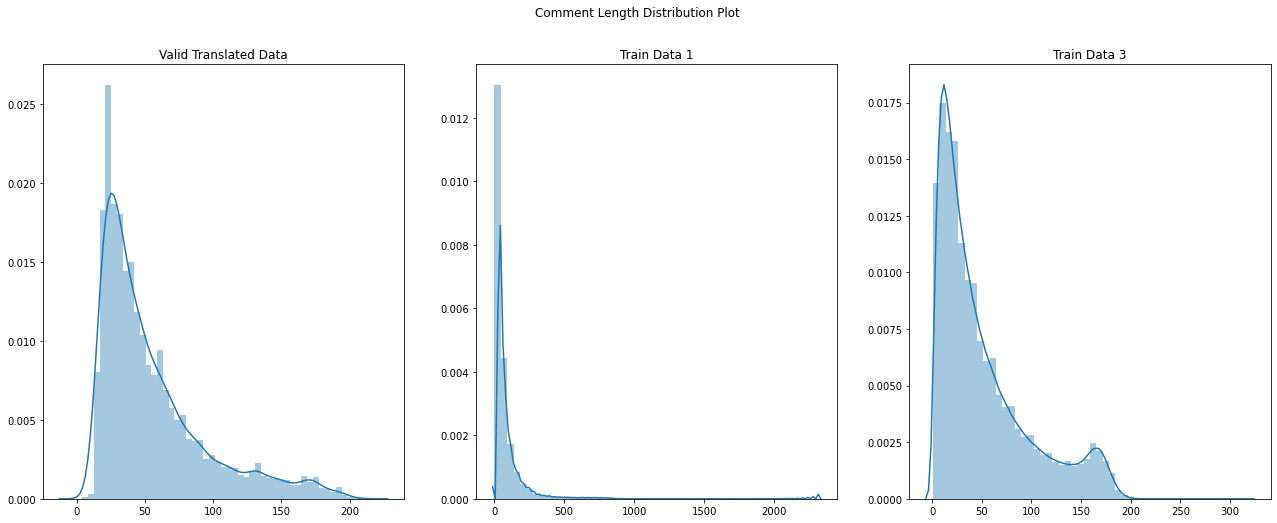

<Figure size 1584x360 with 0 Axes>

time: 11 s


In [12]:
fig = plt.figure(figsize=(22,8))
fig.suptitle("Comment Length Distribution Plot")
plt.subplot(1,3,1)
com=[]
com.append([len(i.split()) for i in valid_translated.comment_text.values])
plt.title("Valid Translated Data")
sns.distplot(com)

plt.subplot(1,3,2)
com1=[]
com1.append([len(i.split()) for i in train_data1.comment_text.values])
plt.title("Train Data 1")
sns.distplot(com1)

plt.subplot(1,3,3)
com2=[]
com2.append([len(i.split()) for i in train_data3.comment_text.values])
plt.title("Train Data 3")
sns.distplot(com2)
fig = plt.figure(figsize=(22,5))
fig.suptitle("Comment Length Distribution Plot")

(array([8.98811e+05, 4.62714e+05, 2.22490e+05, 1.27250e+05, 9.52050e+04,
        9.31210e+04, 2.59200e+03, 2.00000e+00, 6.00000e+00, 3.00000e+00]),
 array([  1. ,  32.6,  64.2,  95.8, 127.4, 159. , 190.6, 222.2, 253.8,
        285.4, 317. ]),
 <a list of 10 Patch objects>)

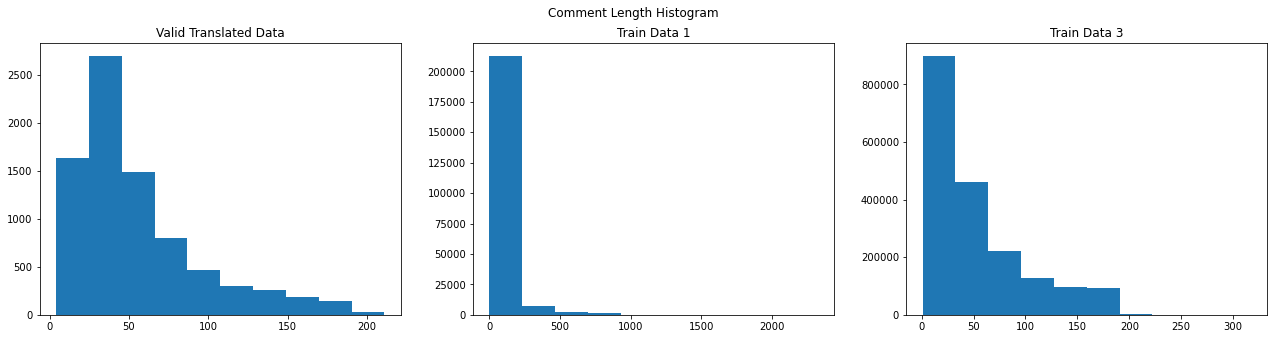

time: 10.5 s


In [13]:
fig = plt.figure(figsize=(22,5))
fig.suptitle("Comment Length Histogram")
plt.subplot(1,3,1)
com=[]
com.append([len(i.split()) for i in valid_translated.comment_text.values])
plt.title("Valid Translated Data")
plt.hist(com)

plt.subplot(1,3,2)
com1=[]
com1.append([len(i.split()) for i in train_data1.comment_text.values])
plt.title("Train Data 1")
plt.hist(com1)

plt.subplot(1,3,3)
com2=[]
com2.append([len(i.split()) for i in train_data3.comment_text.values])
plt.title("Train Data 3")
plt.hist(com2)

# Looking at the features of the train data

In [14]:
train_data1.head(50)
train1_toxic=train_data1.query('toxic==1')
train1_toxic=train1_toxic[['severe_toxic','obscene','threat','insult','identity_hate']]
train1_toxic.sum(axis=0)

severe_toxic      1962
obscene          11552
threat             654
insult           10686
identity_hate     1995
dtype: int64

time: 17.6 ms


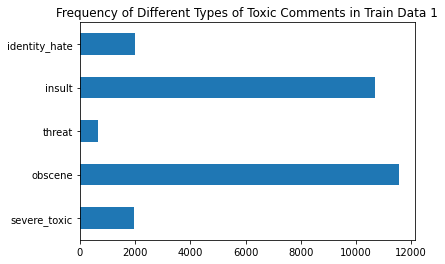

time: 157 ms


In [15]:
plt.title("Frequency of Different Types of Toxic Comments in Train Data 1")
train1_toxic.sum(axis=0).plot(kind='barh')

In [16]:
print(train_data3.query("toxic>0.6 and rating=='approved'").shape)
train_data3.query("toxic>0.6 and rating=='approved'").head()

(56483, 45)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
31,239607,Yet call out all Muslims for the acts of a few...,0.912500,0.050000,0.237500,0.6125,0.887500,0.112500,0.0,0.0,...,26670,approved,0,0,0,1,0,0.0,4,80
123,239762,Took this as an opportunity to check back in o...,0.700000,0.100000,0.000000,0.0000,0.700000,0.000000,NaN,NaN,...,26610,approved,0,0,0,0,0,0.0,0,10
348,240400,"Nincompoop, that's a nice one! I'm partial to ...",0.833333,0.000000,0.000000,0.0000,0.833333,0.000000,0.0,0.0,...,32846,approved,0,0,0,0,0,0.0,4,6
508,240615,"Well shit, they drafted a guide. We should al...",0.818182,0.045455,0.772727,0.0000,0.287879,0.015152,NaN,NaN,...,32847,approved,0,0,0,1,0,0.0,0,66
534,240660,So tired of all these Portlanders moving to Ca...,0.700000,0.000000,0.100000,0.7000,0.300000,0.000000,NaN,NaN,...,33231,approved,0,0,0,4,0,0.0,0,10


time: 435 ms


In [17]:
print(train_data3.query("toxic==0 and rating=='rejected'").shape)
train_data3.query("toxic==0 and rating=='rejected'").head()

(55232, 45)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
7,59863,FFFFUUUUUUUUUUUUUUU,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


time: 272 ms


In [18]:
print(train_data3.query("toxic==0 and toxicity_annotator_count>1000").shape)
train_data3.query("toxic==0 and toxicity_annotator_count>1000").tail()

(20, 45)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1649226,6143548,Me too!,0.0,0.0,0.000000,0.0,0.000624,0.0,NaN,NaN,...,388548,approved,0,0,0,0,0,0.0,0,1602
1702845,6209923,Will you be voting in Kent?,0.0,0.0,0.000000,0.0,0.000000,0.0,NaN,NaN,...,391609,approved,0,0,0,0,0,0.0,0,1381
1788090,6312975,"In the future I will, but right now we are con...",0.0,0.0,0.000000,0.0,0.000000,0.0,NaN,NaN,...,397887,approved,0,0,0,0,0,0.0,0,1393
1789628,6314817,"In the end, the full cost with interest could ...",0.0,0.0,0.000000,0.0,0.000000,0.0,NaN,NaN,...,398270,approved,0,0,0,0,0,0.0,0,1149
1880814,7173260,Not what I said.,0.0,0.0,0.000743,0.0,0.000000,0.0,NaN,NaN,...,147700,approved,0,0,0,0,0,0.0,0,1346


time: 68.5 ms


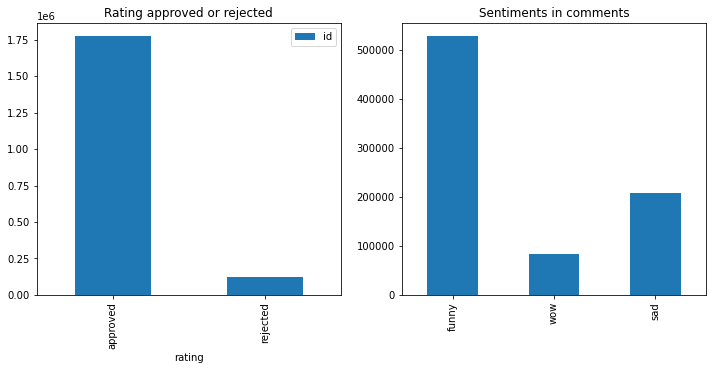

time: 1.87 s


In [19]:
plt.figure(figsize=(12,5))
train_data3.groupby(['rating'])\
           .count()[['id']]\
           .plot(y='id',kind='bar',title='Rating approved or rejected',ax=plt.subplot(121))

train_data3[['funny','wow','sad']].sum(axis=0).plot(kind='bar',ax=plt.subplot(122),title='Sentiments in comments')

# THE END